# Import necessary libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
train = pd.read_csv('train.csv')
submission = pd.read_csv('test.csv')

In [3]:
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20191 entries, 0 to 20190
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20191 non-null  int64  
 1   Sex             20191 non-null  object 
 2   Length          20191 non-null  float64
 3   Diameter        20191 non-null  float64
 4   Height          20191 non-null  float64
 5   Weight          20191 non-null  float64
 6   Shucked Weight  20191 non-null  float64
 7   Viscera Weight  20191 non-null  float64
 8   Shell Weight    20191 non-null  float64
 9   Age             20191 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 1.5+ MB


In [5]:
train.shape

(20191, 10)

In [6]:
train.isnull().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

In [7]:
train.duplicated(keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
20186    False
20187    False
20188    False
20189    False
20190    False
Length: 20191, dtype: bool

In [8]:
train[train.duplicated(keep=False)]

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age


In [9]:
train.drop(columns=['id'], axis=1).describe(include='all')

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,20191,20191.000000,20191.000000,20191.000000,20191.000000,20191.000000,20191.000000,20191.000000,20191.000000
unique,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.317672,1.024637,0.348064,23.400403,10.121481,5.061241,6.724716,9.953246
std,NaN,0.288066,0.237790,0.093185,12.717732,5.644895,2.801545,3.599905,3.170614
min,NaN,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,NaN,1.150000,0.887500,0.287500,13.437663,5.712424,2.849125,3.968930,8.000000
50%,NaN,1.375000,1.075000,0.362500,23.785231,9.908150,4.975337,6.803880,10.000000
75%,NaN,1.537500,1.200000,0.412500,32.318430,14.068439,7.002326,9.128539,11.000000


From the above we can see that there are neither missing values in the dataset nor duplicates. Also, looking carefully at the summary stats for each numerical feature, we can see that their means are not to far from their medians. Suggesting that all features may follow a normal distribution.

# Exploratory Data Analysis

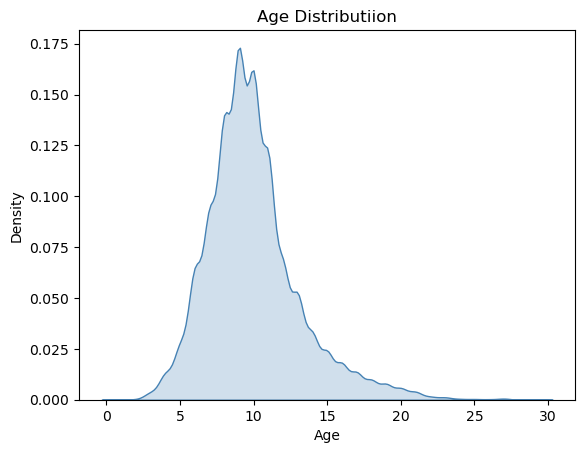

In [10]:
g = sns.kdeplot(data=train,
                x='Age',
                fill=True,
                color='steelblue')

g.set_title('Age Distributiion')
plt.show()

The distributions appears to somewhat follow a normal distribution.

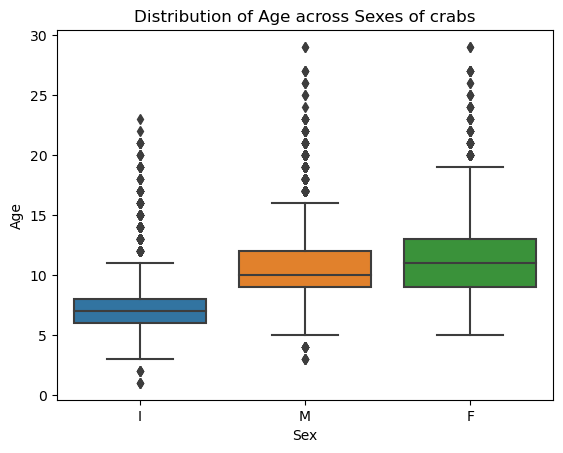

In [11]:
g = sns.boxplot(data=train,
                x='Sex',
                y='Age')

g.set_title('Distribution of Age across Sexes of crabs')
plt.show()

In [12]:
train.corr().style.background_gradient('coolwarm')

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
id,1.000000,-0.006638,-0.007202,-0.004803,-0.009734,-0.009902,-0.010351,-0.008961,-0.003395
Length,-0.006638,1.000000,0.989261,0.909915,0.936107,0.915552,0.918598,0.917170,0.618512
Diameter,-0.007202,0.989261,1.000000,0.913774,0.938894,0.914682,0.919822,0.923797,0.627650
Height,-0.004803,0.909915,0.913774,1.000000,0.892543,0.856741,0.874066,0.894293,0.633972
Weight,-0.009734,0.936107,0.938894,0.892543,1.000000,0.971409,0.970994,0.965972,0.607950
Shucked Weight,-0.009902,0.915552,0.914682,0.856741,0.971409,1.000000,0.943147,0.911186,0.511906
Viscera Weight,-0.010351,0.918598,0.919822,0.874066,0.970994,0.943147,1.000000,0.935042,0.582643
Shell Weight,-0.008961,0.917170,0.923797,0.894293,0.965972,0.911186,0.935042,1.000000,0.670578
Age,-0.003395,0.618512,0.627650,0.633972,0.607950,0.511906,0.582643,0.670578,1.000000


From the above, we see that **`Shell Weight`** is the feature that correlate the most with **`Age`**. On the other hand, **`Shucked Weight`** is the feature that correlate the least with **`Age`**.

In [13]:
pair1 = train[['Length', 'Diameter', 'Height', 'Age']] 
pair2 = train[['Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Age']]

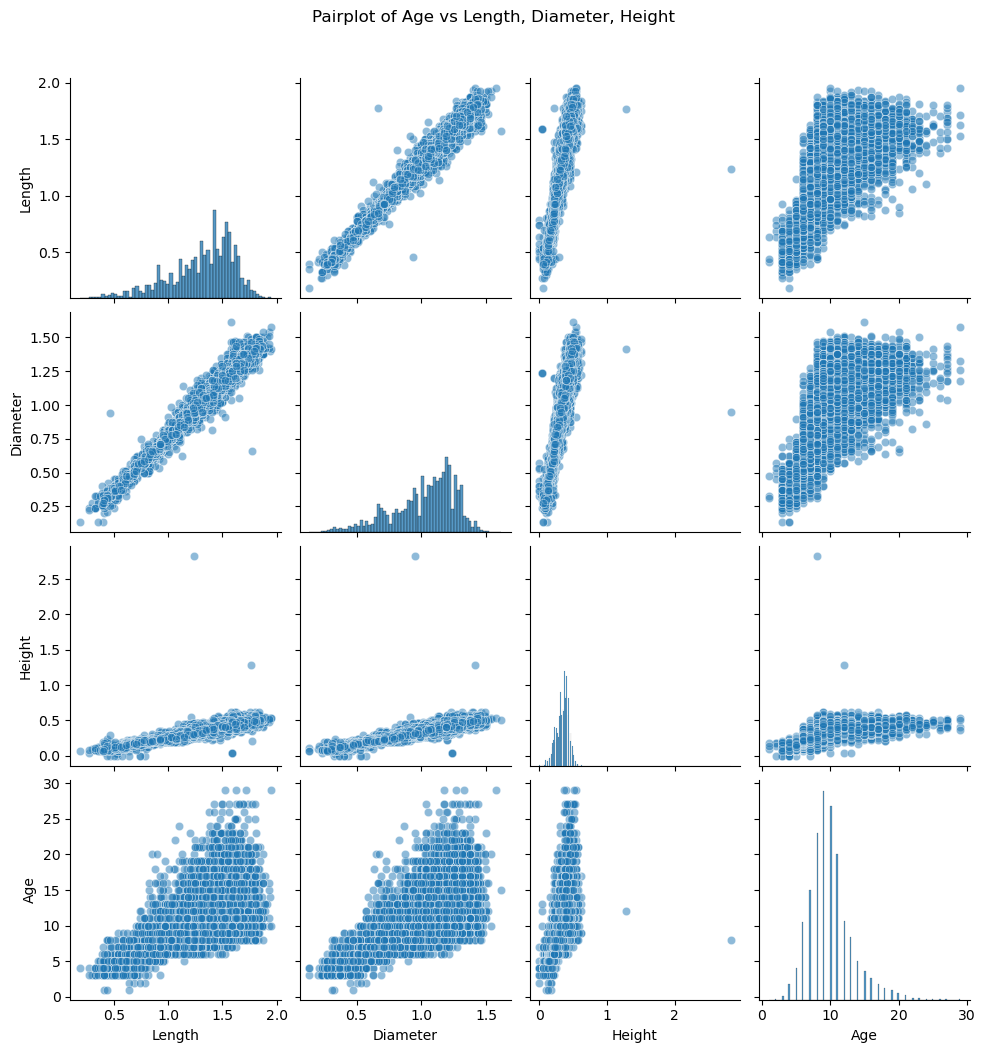

In [14]:
g = sns.pairplot(pair1,
                 kind='scatter',
                 plot_kws={'alpha':0.5})

g.fig.suptitle('Pairplot of Age vs Length, Diameter, Height', y=1.05)
plt.show()

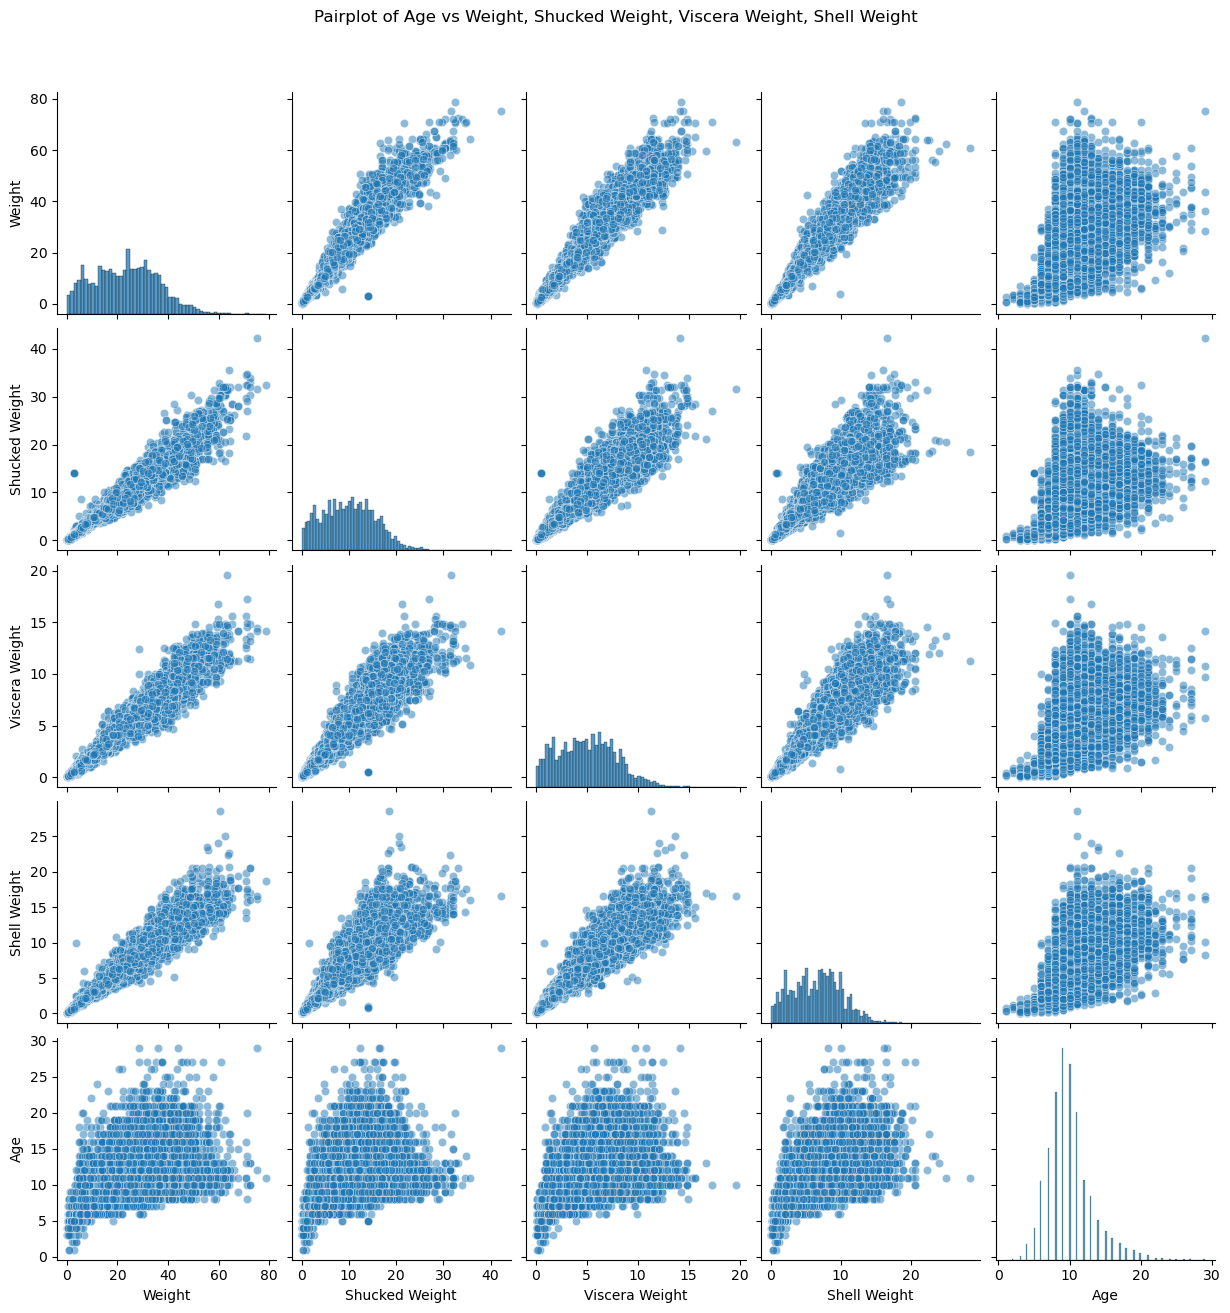

In [15]:
g = sns.pairplot(pair2,
                 kind='scatter',
                 plot_kws={'alpha':0.5})

g.fig.suptitle('Pairplot of Age vs Weight, Shucked Weight, Viscera Weight, Shell Weight', y=1.05)
plt.show()

# Data Preprocessing

#### Split data into train and test set as good practice to avoid **_data leakage_**.

In [16]:
X = train[['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']]
y = train['Age']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep='\n')

(16152, 8)
(16152,)
(4039, 8)
(4039,)


In [19]:
X_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
8182,I,0.6375,0.4625,0.1500,2.168737,0.978058,0.524466,0.708738
9406,M,1.3750,1.0875,0.3625,22.920571,8.462326,4.861939,6.236890
12941,I,1.4875,1.1500,0.3625,32.020760,16.159215,7.243297,7.512618
11931,F,1.2750,1.0000,0.3625,17.449117,5.712424,3.685435,5.811648
11109,F,1.3500,1.0625,0.3625,22.041736,7.852811,6.406987,6.520385


#### Class balance

In [20]:
X_train.Sex.value_counts()

M    5895
I    5222
F    5035
Name: Sex, dtype: int64

#### LabelEncode the `Sex` column

In [21]:
le = LabelEncoder()

X_train['Sex'] = le.fit_transform(X_train['Sex'])

X_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
8182,1,0.6375,0.4625,0.1500,2.168737,0.978058,0.524466,0.708738
9406,2,1.3750,1.0875,0.3625,22.920571,8.462326,4.861939,6.236890
12941,1,1.4875,1.1500,0.3625,32.020760,16.159215,7.243297,7.512618
11931,0,1.2750,1.0000,0.3625,17.449117,5.712424,3.685435,5.811648
11109,0,1.3500,1.0625,0.3625,22.041736,7.852811,6.406987,6.520385


In [22]:
X_test['Sex'] = le.transform(X_test['Sex'])
X_test.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
2169,2,1.4375,1.1125,0.4125,23.657658,10.631063,5.074560,6.803880
8222,2,1.3625,1.1000,0.3500,22.665425,10.305043,4.819415,6.038443
4263,0,1.3625,1.0875,0.3750,22.821348,8.334753,5.599026,8.150481
7072,2,1.5000,1.2375,0.3625,30.986003,14.514944,6.265239,8.930093
9453,1,1.4500,1.1375,0.3625,24.210473,10.390092,4.635143,6.945627


In [23]:
submission['Sex'] = le.transform(submission['Sex'])
submission.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,1,1.0500,0.7625,0.2750,8.618248,3.657085,1.729319,2.721552
1,74052,1,1.1625,0.8875,0.2750,15.507176,7.030676,3.246018,3.968930
2,74053,0,1.2875,0.9875,0.3250,14.571643,5.556502,3.883882,4.819415
3,74054,0,1.5500,0.9875,0.3875,28.377849,13.380964,6.548735,7.030676
4,74055,1,1.1125,0.8500,0.2625,11.765042,5.528153,2.466407,3.331066


#### Standardization

In [24]:
X_train.var()

Sex                 0.673903
Length              0.083254
Diameter            0.056714
Height              0.008783
Weight            161.650757
Shucked Weight     31.787792
Viscera Weight      7.875028
Shell Weight       12.947233
dtype: float64

The **`Weight`** feature has significantly higher variance than all the other features. This makes it a good candidate for log normalization as a method of **_standardization_**.

#### Log Normalization for features with high variance - **`Weight`**

In [25]:
X_train['Weight'] = np.log(X_train['Weight'])
X_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
8182,1,0.6375,0.4625,0.1500,0.774145,0.978058,0.524466,0.708738
9406,2,1.3750,1.0875,0.3625,3.132035,8.462326,4.861939,6.236890
12941,1,1.4875,1.1500,0.3625,3.466384,16.159215,7.243297,7.512618
11931,0,1.2750,1.0000,0.3625,2.859289,5.712424,3.685435,5.811648
11109,0,1.3500,1.0625,0.3625,3.092938,7.852811,6.406987,6.520385


In [26]:
X_test['Weight'] = np.log(X_test['Weight'])
X_test.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
2169,2,1.4375,1.1125,0.4125,3.163687,10.631063,5.074560,6.803880
8222,2,1.3625,1.1000,0.3500,3.120841,10.305043,4.819415,6.038443
4263,0,1.3625,1.0875,0.3750,3.127696,8.334753,5.599026,8.150481
7072,2,1.5000,1.2375,0.3625,3.433536,14.514944,6.265239,8.930093
9453,1,1.4500,1.1375,0.3625,3.186785,10.390092,4.635143,6.945627


In [27]:
submission['Weight'] = np.log(submission['Weight'])
submission.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,1,1.0500,0.7625,0.2750,2.153882,3.657085,1.729319,2.721552
1,74052,1,1.1625,0.8875,0.2750,2.741303,7.030676,3.246018,3.968930
2,74053,0,1.2875,0.9875,0.3250,2.679077,5.556502,3.883882,4.819415
3,74054,0,1.5500,0.9875,0.3875,3.345609,13.380964,6.548735,7.030676
4,74055,1,1.1125,0.8500,0.2625,2.465133,5.528153,2.466407,3.331066


In [28]:
X_train.var()

Sex                0.673903
Length             0.083254
Diameter           0.056714
Height             0.008783
Weight             0.654216
Shucked Weight    31.787792
Viscera Weight     7.875028
Shell Weight      12.947233
dtype: float64

#### Feature scaling with **`StandardScaler`** for features with different scales

In [29]:
features = ['Shucked Weight', 'Viscera Weight', 'Shell Weight']
for feat in features:
    scaler = StandardScaler()
    X_train[feat] = scaler.fit_transform(X_train[feat].values.reshape(-1, 1))
    X_test[feat] = scaler.fit_transform(X_test[feat].values.reshape(-1, 1))
    submission[feat] = scaler.transform(submission[feat].values.reshape(-1, 1))

X_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
8182,1,0.6375,0.4625,0.1500,0.774145,-1.617085,-1.613602,-1.668294
9406,2,1.3750,1.0875,0.3625,3.132035,-0.289591,-0.067906,-0.131892
12941,1,1.4875,1.1500,0.3625,3.466384,1.075616,0.780712,0.222663
11931,0,1.2750,1.0000,0.3625,2.859289,-0.777344,-0.487163,-0.250077
11109,0,1.3500,1.0625,0.3625,3.092938,-0.397701,0.482686,-0.053102


In [30]:
X_test.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
2169,2,1.4375,1.1125,0.4125,3.163687,0.071191,-0.007785,0.007244
8222,2,1.3625,1.1000,0.3500,3.120841,0.013701,-0.099485,-0.205017
4263,0,1.3625,1.0875,0.3750,3.127696,-0.333739,0.180710,0.380665
7072,2,1.5000,1.2375,0.3625,3.433536,0.756073,0.420150,0.596856
9453,1,1.4500,1.1375,0.3625,3.186785,0.028699,-0.165713,0.046551


In [31]:
submission.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,1,1.0500,0.7625,0.2750,2.153882,-1.158596,-1.210077,-1.124812
1,74052,1,1.1625,0.8875,0.2750,2.741303,-0.563699,-0.664970,-0.778906
2,74053,0,1.2875,0.9875,0.3250,2.679077,-0.823654,-0.435720,-0.543061
3,74054,0,1.5500,0.9875,0.3875,3.345609,0.556107,0.522039,0.070136
4,74055,1,1.1125,0.8500,0.2625,2.465133,-0.828653,-0.945165,-0.955789


In [32]:
X_train.var()

Sex               0.673903
Length            0.083254
Diameter          0.056714
Height            0.008783
Weight            0.654216
Shucked Weight    1.000062
Viscera Weight    1.000062
Shell Weight      1.000062
dtype: float64

# Baseline Model

In [33]:
X_train.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
8182,1,0.6375,0.4625,0.1500,0.774145,-1.617085,-1.613602,-1.668294
9406,2,1.3750,1.0875,0.3625,3.132035,-0.289591,-0.067906,-0.131892
12941,1,1.4875,1.1500,0.3625,3.466384,1.075616,0.780712,0.222663
11931,0,1.2750,1.0000,0.3625,2.859289,-0.777344,-0.487163,-0.250077
11109,0,1.3500,1.0625,0.3625,3.092938,-0.397701,0.482686,-0.053102


In [34]:
y_train.head()

8182      5
9406      9
12941    10
11931    13
11109    12
Name: Age, dtype: int64

### Linear Regression

In [35]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
predictions = linreg.predict(X_test)
predictions

array([10.29373136,  9.55854852, 12.29909826, ..., 10.92776665,
        7.03565691,  9.1758369 ])

In [36]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', mean_squared_error(y_test, predictions, squared=False))
print('R-squared:', linreg.score(X_test, y_test))

Mean Absolute Error: 1.4651633654513374
Mean Squared Error: 4.431509388493531
Root Mean Squared Error: 2.105115053505041
R-squared: 0.5487588672560044


### Lasso Regression

In [37]:
lasso = Lasso()
lasso.fit(X_train, y_train)
predictions = lasso.predict(X_test)
predictions

array([ 9.94831886,  9.7065831 , 10.37359473, ...,  9.99308474,
        8.42627888,  9.45589416])

In [38]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', mean_squared_error(y_test, predictions, squared=False))
print('R-squared:', lasso.score(X_test, y_test))

Mean Absolute Error: 1.8087979716776545
Mean Squared Error: 6.397018793255038
Root Mean Squared Error: 2.529232846784779
R-squared: 0.3486196793471501


### Ridge Regression

In [39]:
ridge = Ridge()
ridge.fit(X_train, y_train)
predictions = ridge.predict(X_test)
predictions

array([10.28676868,  9.55621817, 12.29608118, ..., 10.92941996,
        7.03651958,  9.1803407 ])

In [40]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', mean_squared_error(y_test, predictions, squared=False))
print('R-squared:', ridge.score(X_test, y_test))

Mean Absolute Error: 1.4652621296040953
Mean Squared Error: 4.43287142989875
Root Mean Squared Error: 2.1054385362434
R-squared: 0.5486201765633634


### Decision Tree Regressor

In [41]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
predictions

array([10.,  8., 13., ..., 12.,  6.,  8.])

In [42]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', mean_squared_error(y_test, predictions, squared=False))
print('R-squared:', dt.score(X_test, y_test))

Mean Absolute Error: 2.0024758603614754
Mean Squared Error: 8.758603614756128
Root Mean Squared Error: 2.9594938105622264
R-squared: 0.10814987177049529


### Random Forest Regressor

In [43]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
predictions

array([10.23,  9.22, 12.77, ..., 11.28,  6.64,  9.2 ])

In [44]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', mean_squared_error(y_test, predictions, squared=False))
print('R-squared:', rf.score(X_test, y_test))

Mean Absolute Error: 1.4652587274077742
Mean Squared Error: 4.3865497400346625
Root Mean Squared Error: 2.094409162516881
R-squared: 0.5533369107440829


### Extreme Gradient Boosting Regressor

In [45]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
predictions

array([ 9.643276,  9.491119, 11.917395, ..., 10.673585,  6.593394,
        8.676578], dtype=float32)

In [46]:
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', mean_squared_error(y_test, predictions, squared=False))
print('R-squared:', xgb.score(X_test, y_test))

Mean Absolute Error: 1.4529501853469693
Mean Squared Error: 4.4887318370413745
Root Mean Squared Error: 2.118662747357723
R-squared: 0.5429321567071881


#### Save LinearRegression output as submission file

In [47]:
submission.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,74051,1,1.0500,0.7625,0.2750,2.153882,-1.158596,-1.210077,-1.124812
1,74052,1,1.1625,0.8875,0.2750,2.741303,-0.563699,-0.664970,-0.778906
2,74053,0,1.2875,0.9875,0.3250,2.679077,-0.823654,-0.435720,-0.543061
3,74054,0,1.5500,0.9875,0.3875,3.345609,0.556107,0.522039,0.070136
4,74055,1,1.1125,0.8500,0.2625,2.465133,-0.828653,-0.945165,-0.955789


In [48]:
X_submit = submission.drop(columns=['id'], axis=1)
X_submit.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight
0,1,1.0500,0.7625,0.2750,2.153882,-1.158596,-1.210077,-1.124812
1,1,1.1625,0.8875,0.2750,2.741303,-0.563699,-0.664970,-0.778906
2,0,1.2875,0.9875,0.3250,2.679077,-0.823654,-0.435720,-0.543061
3,0,1.5500,0.9875,0.3875,3.345609,0.556107,0.522039,0.070136
4,1,1.1125,0.8500,0.2625,2.465133,-0.828653,-0.945165,-0.955789


In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_submit)
submission['Yield'] = predictions
submission.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Yield
0,74051,1,1.0500,0.7625,0.2750,2.153882,-1.158596,-1.210077,-1.124812,7.911195
1,74052,1,1.1625,0.8875,0.2750,2.741303,-0.563699,-0.664970,-0.778906,8.410383
2,74053,0,1.2875,0.9875,0.3250,2.679077,-0.823654,-0.435720,-0.543061,9.762245
3,74054,0,1.5500,0.9875,0.3875,3.345609,0.556107,0.522039,0.070136,9.340659
4,74055,1,1.1125,0.8500,0.2625,2.465133,-0.828653,-0.945165,-0.955789,8.052110


In [50]:
submission[['id', 'Yield']].to_csv('submission.csv', index=False)